# Previsão de Acidentes em Rodovias Federais 
Trabalho de Conclusão de Curso do MBA em Ciência de Dados (ICMC-USP)

Autor: Saulo Giovani de Matos Silva

A previsão de acidentes utiliza dados disponibilizados pela PRF no portal da transparência ([site](https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-acidentes)). São utilizados os acidentes à partir de 2016, e os acidentes são agrupados por estado e por semana. O escopo desse projeto é a previsão de acidentes semanais para o estado de Minas Gerais. 

Os dados dos anos de 2016 a 2020 são utilizados como referência de treino para a análise descritiva e os dados do ano de 2021 são utilizados de referência de teste para a validação e comparação das previsões. Aplica-se uma previsão com janela deslizante e horizonte de 5 passos. 

## Bibliotecas e Funções 

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss,adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error

from fbprophet import Prophet

import tensorflow as tf
from tensorflow import keras
from tensorflow.random import set_seed
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

Importing plotly failed. Interactive plots will not work.


In [2]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [3]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')

## Leitura de Arquivos 

In [4]:
years = range(2007,2022)

list_datatran = []

for year in years:
    list_datatran.append(pd.read_csv(f"../data/raw/datatran{year}.csv", delimiter=";", encoding='iso-8859-1'))
    
df_datatran = pd.concat(list_datatran)

/home/saulog/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# Conversão da Data para formato pandas date 
df_datatran['Date'] = pd.to_datetime(df_datatran['data_inversa'])

# Etiqueta de Acidentes com vítima fatal
df_datatran['contem_vitima_fatal'] = df_datatran.apply(lambda x: 1 if x['mortos'] != 0 else 0, axis=1)
# Filtra colunas
df_datatran = df_datatran[['uf', 'municipio', 'Date', 'contem_vitima_fatal']] 
# Exclui estados nulos
df_datatran = df_datatran[df_datatran['uf'] != '(null)'] 

# Padronização dos nomes dos municípios
df_datatran[['municipio']] = df_datatran[['municipio']].apply(
    lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.
    decode('utf-8').str.replace('[^\w\s]', '').str.lower().str.strip())

# Definição das Semanas
df_datatran['WeekSunday'] = df_datatran['Date'].dt.to_period('W-SUN').apply(lambda r: r.start_time)
#df_datatran['Month'] = df_datatran['Date'].dt.to_period('M').dt.to_timestamp()

#Criação da série temporal semanal por Estado
ts_week_estado = pd.crosstab(index = df_datatran['WeekSunday'], columns = df_datatran['uf'], dropna=True, normalize=False)
ts_week_estado = ts_week_estado[ts_week_estado.sum().sort_values(ascending=False).index]

ts_week_estado.to_parquet('../data/processed/ts_week_estado.parquet')

<ipython-input-5-40b8cf15161b>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.


In [6]:
ts_week_estado = pd.read_parquet('../data/processed/ts_week_estado.parquet')
ts_week_estado = ts_week_estado[ts_week_estado.index.year >= 2016]

# Estado de MG
df = ts_week_estado.iloc[:,[0]].reset_index()
df.columns = ['ds', 'y']

# Define threshold date.
mask = df.ds.dt.year < 2021
# Split the data and select `ds` and `y` columns.
df_train = df[mask]
df_test = df[~ mask]

# Tamanho do Dataset de Teste
len_test = len(df_test)
# Horizonte de Decisão
horizon = 4

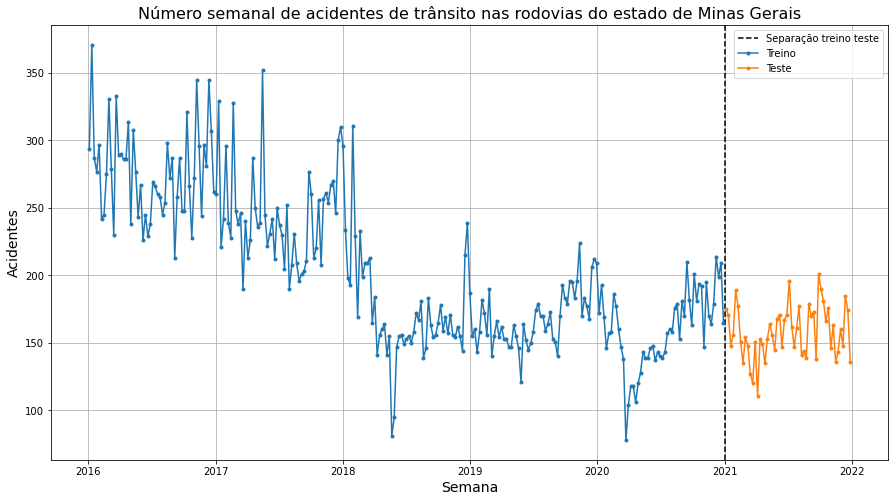

In [7]:
plt.figure(figsize=(15,8))
plt.axvline(x = pd.to_datetime('2021-01-01'),c='black',linestyle='--', label='Separação treino teste')
plt.plot(df_train['ds'], df_train['y'], ls = '-', marker = '.', label = 'Treino')
plt.plot(df_test['ds'], df_test['y'], ls = '-', marker = '.', label = 'Teste')

plt.title('Número semanal de acidentes de trânsito nas rodovias do estado de Minas Gerais', fontsize=16)
plt.ylabel('Acidentes', fontsize=14)
plt.xlabel('Semana', fontsize=14)

plt.grid()
plt.legend()
plt.savefig("imagesTCC/serietemporal.pdf", bbox_inches='tight')
plt.show()

# Análise Descritiva

A análise descritiva é realizada apenas nos dados de treino. 

## Decomposição 

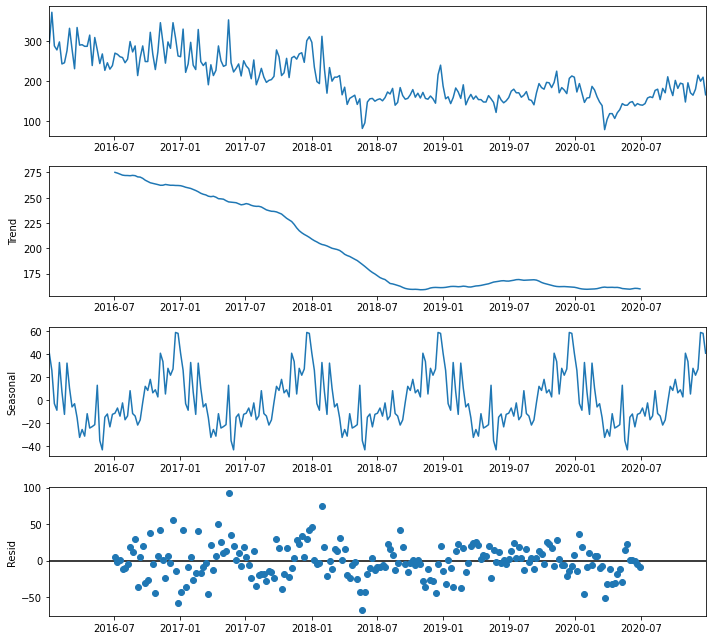

In [8]:
result = seasonal_decompose(df_train.set_index('ds'), model='additive')
plt.rcParams.update({'figure.figsize':(10,9)})
result.plot()
plt.savefig("imagesTCC/decomposicao.pdf", bbox_inches='tight')

## Estacionariedade

### Tendência

In [9]:
kpss_test(result.trend.dropna())

KPSS Statistic: 1.2700339616831915
p-value: 0.01
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


/home/saulog/anaconda3/envs/MBATCC/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/saulog/anaconda3/envs/MBATCC/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [10]:
adf_test(result.trend.dropna())

ADF Statistic: -1.415751446110339
p-value: 0.574701816781313
Critial Values:
   1%, -3.463987334463603
Critial Values:
   5%, -2.8763259091636213
Critial Values:
   10%, -2.5746515171738515
Result: The series is not stationary


### Sazonalidade

In [11]:
kpss_test(result.seasonal.dropna())

KPSS Statistic: 0.042288628932603635
p-value: 0.1
num lags: 16
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/home/saulog/anaconda3/envs/MBATCC/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/saulog/anaconda3/envs/MBATCC/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [12]:
adf_test(result.seasonal.dropna())

ADF Statistic: -7.201236468204901
p-value: 2.3625032390833437e-10
Critial Values:
   1%, -3.4573260719088132
Critial Values:
   5%, -2.873410402808354
Critial Values:
   10%, -2.573095980841316
Result: The series is stationary


### Resíduo

In [13]:
kpss_test(result.resid.dropna())

KPSS Statistic: 0.0662718049454572
p-value: 0.1
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/home/saulog/anaconda3/envs/MBATCC/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/saulog/anaconda3/envs/MBATCC/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [14]:
adf_test(result.resid.dropna())

ADF Statistic: -4.62045028767426
p-value: 0.00011841109660367329
Critial Values:
   1%, -3.4646940755442612
Critial Values:
   5%, -2.8766348847254934
Critial Values:
   10%, -2.5748163958763994
Result: The series is stationary


## ACF/PACF

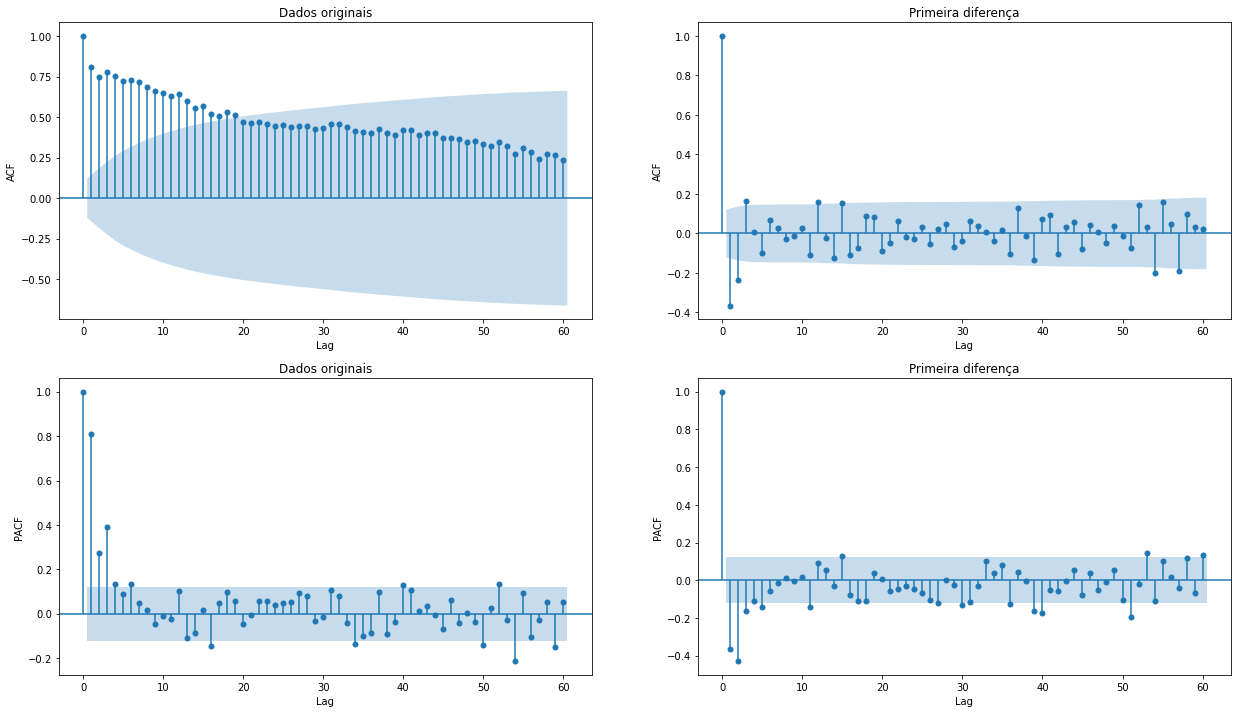

In [15]:
df_train_diff = df_train.y.diff(periods=1).values[1:]

fig, axes = plt.subplots(2,2,figsize=(21, 12))
nlags = 60
fig = plot_acf(df_train.y, lags=nlags, ax=axes[0,0])
axes[0,0].set_title('Dados originais')
axes[0,0].set_xlabel('Lag')
axes[0,0].set_ylabel('ACF')

fig = plot_acf(df_train_diff, lags=nlags, ax=axes[0,1])
axes[0,1].set_title('Primeira diferença')
axes[0,1].set_xlabel('Lag')
axes[0,1].set_ylabel('ACF')

fig = plot_pacf(df_train.y, lags=nlags, ax=axes[1,0])
axes[1,0].set_title('Dados originais')
axes[1,0].set_xlabel('Lag')
axes[1,0].set_ylabel('PACF')

fig = plot_pacf(df_train_diff, lags=nlags, ax=axes[1,1])
axes[1,1].set_title('Primeira diferença')
axes[1,1].set_xlabel('Lag')
axes[1,1].set_ylabel('PACF')

plt.savefig("imagesTCC/autocorrelacao.pdf", bbox_inches='tight')
plt.show()

# Modelagem

## Benchmark 

In [16]:
test_true_values = df.y.values[-52:]
test_predictions_naive = df.y.values[:-5][-52:]

RSME_BASE = np.sqrt(mean_squared_error(test_true_values, test_predictions_naive))
print("Naive: %.5f" % RSME_BASE)

Naive: 28.30228


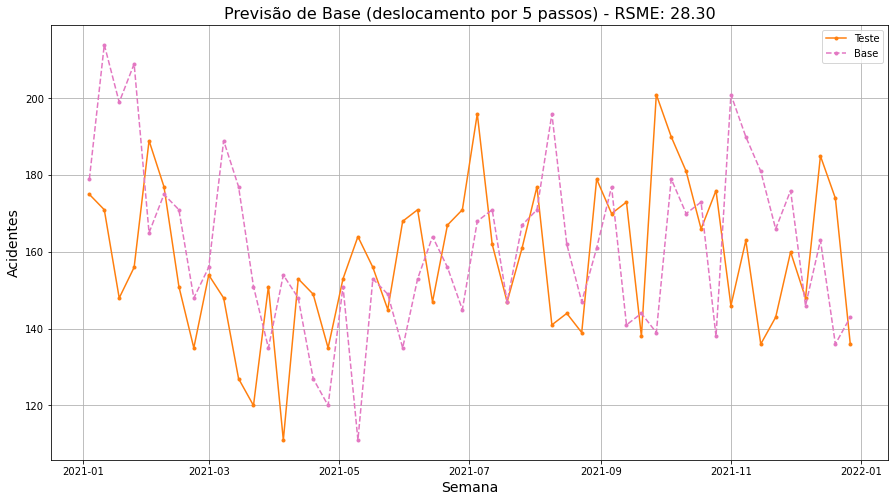

In [17]:
plt.figure(figsize=(15,8))
plt.plot(df_test['ds'], df_test['y'], ls = '-', marker='.', color = 'tab:orange', label = 'Teste')
plt.plot(df_test['ds'], test_predictions_naive, ls = '--', marker='.', color = 'tab:pink', label = 'Base')

plt.title('Previsão de Base (deslocamento por 5 passos) - RSME: %.2f' % RSME_BASE, fontsize=16)
plt.ylabel('Acidentes', fontsize=14)
plt.xlabel('Semana', fontsize=14)

plt.grid()
plt.legend()
plt.savefig("imagesTCC/previsao_benchmark.pdf", bbox_inches='tight')
plt.show()

## ARIMA

### Auto-ARIMA para escolha do modelo

### Previsão Walk-Foward ARIMA

In [18]:
test_predictions_ARIMA = []

for i in np.arange(52):    
    train_loop = df.iloc[:-(len_test+horizon-i)]
    test_loop = df.iloc[-(len_test-i)]
    
    # We train the model with the training data.
    modelo = SARIMAX(train_loop['y'], order=(2,1,1))
    resultado = modelo.fit()
    #inicio=len(train_loop)
    fim=len(train_loop)+horizon
    #previsões = resultado.predict(start=inicio, end=fim, dynamic=True, typ='levels')
    previsões = resultado.predict(fim)
    
    test_predictions_ARIMA.append(previsões.values[-1])

In [19]:
RSME_ARIMA = np.sqrt(mean_squared_error(test_true_values, test_predictions_ARIMA))
print("ARIMA: %.5f" % RSME_ARIMA)

ARIMA: 24.81935


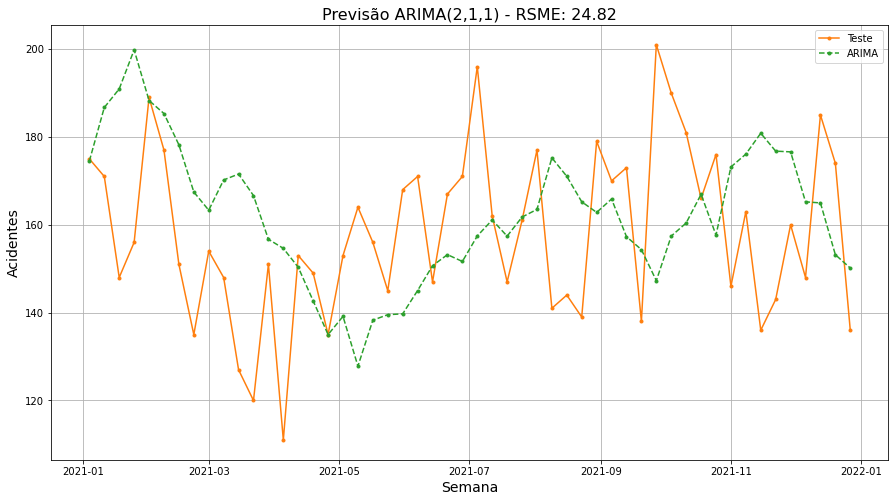

In [20]:
plt.figure(figsize=(15,8))
plt.plot(df_test['ds'], df_test['y'], ls = '-', marker='.', color = 'tab:orange', label = 'Teste')
plt.plot(df_test['ds'], test_predictions_ARIMA, ls = '--', marker='.', color = 'tab:green', label = 'ARIMA')

plt.title('Previsão ARIMA(2,1,1) - RSME: %.2f' % RSME_ARIMA, fontsize=16)
plt.ylabel('Acidentes', fontsize=14)
plt.xlabel('Semana', fontsize=14)

plt.grid()
plt.legend()
plt.savefig("imagesTCC/previsao_arima.pdf", bbox_inches='tight')
plt.show()

## SARIMA
Sazonalidade 52 (número aproximado de semanas no ano) 

### Auto-ARIMA para escolha do modelo

### Previsão Walk-Foward SARIMA

In [21]:
test_predictions_SARIMA = []

for i in np.arange(52):    
    train_loop = df.iloc[:-(len_test+horizon-i)]
    test_loop = df.iloc[-(len_test-i)]
    
    # We train the model with the training data.
    modelo = SARIMAX(train_loop['y'], order=(2,1,1), seasonal_order=(1,0,0,52))
    resultado = modelo.fit()
    #inicio=len(train_loop)
    fim=len(train_loop)+horizon
    #previsões = resultado.predict(start=inicio, end=fim, dynamic=True, typ='levels')
    previsões = resultado.predict(fim)
    
    test_predictions_SARIMA.append(previsões.values[-1])

In [22]:
RSME_SARIMA = np.sqrt(mean_squared_error(test_true_values, test_predictions_SARIMA))
print("SARIMA: %.5f" % RSME_SARIMA)

SARIMA: 22.61367


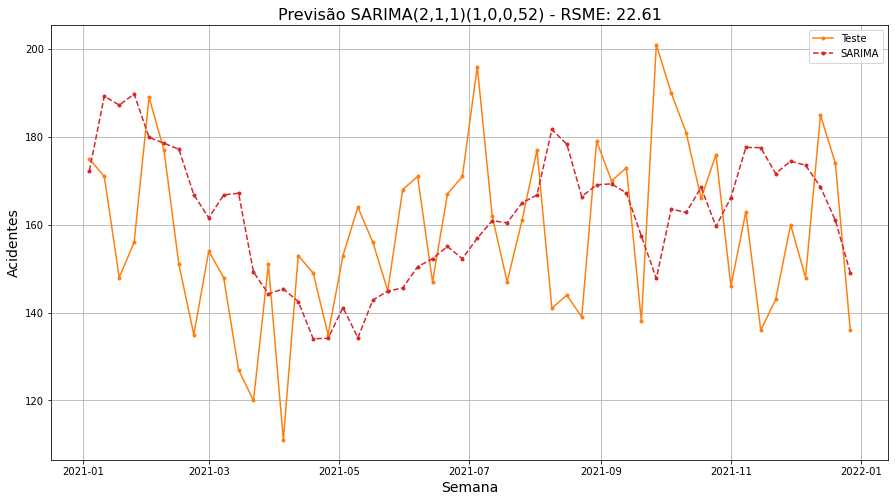

In [23]:
plt.figure(figsize=(15,8))
plt.plot(df_test['ds'], df_test['y'], ls = '-', marker='.', color = 'tab:orange', label = 'Teste')
plt.plot(df_test['ds'], test_predictions_SARIMA, ls = '--', marker='.', color = 'tab:red', label = 'SARIMA')

plt.title('Previsão SARIMA(2,1,1)(1,0,0,52) - RSME: %.2f' % RSME_SARIMA, fontsize=16)
plt.ylabel('Acidentes', fontsize=14)
plt.xlabel('Semana', fontsize=14)

plt.grid()
plt.legend()

plt.savefig("imagesTCC/previsao_sarima.pdf", bbox_inches='tight')
plt.show()

## Prophet 

### Previsão Walk-Forward

In [ ]:
test_predictions_PROPHET = []

for i in np.arange(52):    
    
    train_loop = df.iloc[:-(len_test+horizon-i)]
    test_loop = df.iloc[[-(len_test-i)]]
    
    # define the model
    model = Prophet()
    model.fit(train_loop)
    forecast = model.predict(test_loop)

    test_predictions_PROPHET.append(forecast.yhat.iloc[-1])

In [25]:
RSME_PROPHET = np.sqrt(mean_squared_error(test_true_values, test_predictions_PROPHET))
print("PROPHET: %.5f" % RSME_PROPHET)

PROPHET: 24.98186


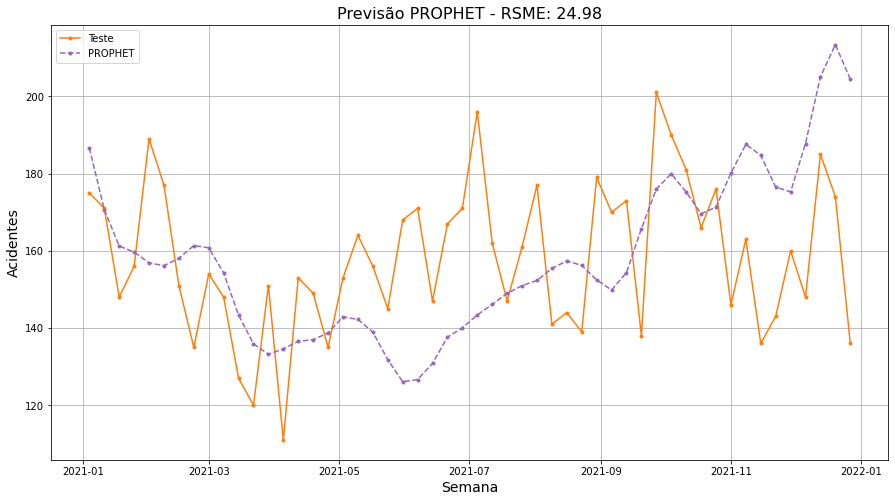

In [26]:
plt.figure(figsize=(15,8))
plt.plot(df_test['ds'], df_test['y'], ls = '-', marker='.', color = 'tab:orange', label = 'Teste')
plt.plot(df_test['ds'], test_predictions_PROPHET, ls = '--', marker='.', color = 'tab:purple', label = 'PROPHET')

plt.title('Previsão PROPHET - RSME: %.2f' % RSME_PROPHET, fontsize=16)
plt.ylabel('Acidentes', fontsize=14)
plt.xlabel('Semana', fontsize=14)

plt.grid()
plt.legend()

plt.savefig("imagesTCC/previsao_prophet.pdf", bbox_inches='tight')
plt.show()

## LSTM (uma camada)

### Normalização e Manipulação

In [27]:
vmax = df_train.y.max()
vmin = df_train.y.min()

df_norm = df.copy()
df_norm['y'] = (df_norm['y'] - vmin)/(vmax - vmin)

series1 = df_norm.y.values[:-horizon]
series2 = df_norm.y.values[horizon:]

# define generator
n_input = 4
generator = TimeseriesGenerator(series1, series2, length=n_input, batch_size=1)

# print each sample
df_norm_x = []
df_norm_y = []
for i in range(len(generator)):
    x, y = generator[i]
    df_norm_x.append(np.transpose(x))
    df_norm_y.append(y)
    #print('%s => %s' % (x, y))

df_norm_x = np.array(df_norm_x)    
df_norm_y = np.array(df_norm_y)

### Definição do Modelo de Rede Neural

In [28]:
batch_size = 1

seed(1)
set_seed(1)

modelLSTM = keras.models.Sequential()
modelLSTM.add(keras.layers.InputLayer((None, 1)))
modelLSTM.add(keras.layers.LSTM(64, activation='relu'))
modelLSTM.add(keras.layers.Dropout(0.2))
modelLSTM.add(keras.layers.Dense(1, activation='relu'))
modelLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [29]:
# testar mais épocas
epochs = 200

# compilacao e treinamento
modelLSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

### Previsão Walk-Forward LSTM (Apenas na entrada)

In [30]:
test_predictions_LSTM_norm = []
i = 0

train_loop_x = df_norm_x[:-(len_test+horizon-i)]
train_loop_y = df_norm_y[:-(len_test+horizon-i)]

histLSTM = modelLSTM.fit(train_loop_x, train_loop_y,  
                  batch_size=batch_size, epochs=epochs,
                  shuffle=False, verbose=0)

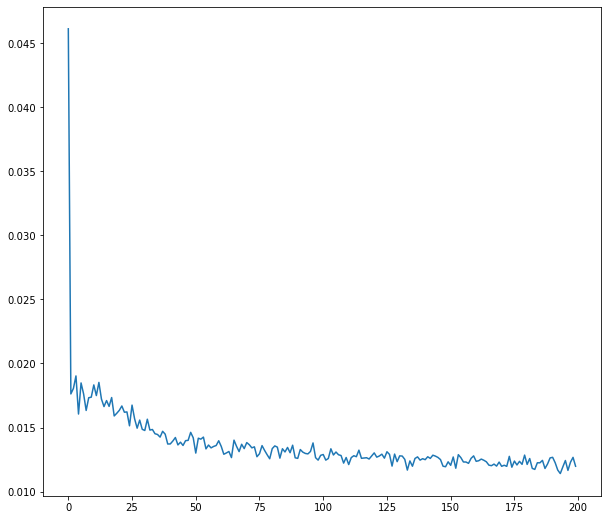

In [31]:
plt.plot(histLSTM.history['loss'])

In [32]:
for i in np.arange(52):    
    train_loop_x = df_norm_x[:-(len_test+horizon-i)]
    train_loop_y = df_norm_y[:-(len_test+horizon-i)]

    test_loop_x = df_norm_x[[-(len_test-i)]]
    
    # realiza predicoes com os dados de treinamento e teste
    forecast = modelLSTM.predict(test_loop_x)
    forecast = np.reshape(forecast, (-1, 1))
    
    test_predictions_LSTM_norm.append(forecast[0][0])
    
test_predictions_LSTM_norm = np.array(test_predictions_LSTM_norm)
test_predictions_LSTM_umacamada = (test_predictions_LSTM_norm*(vmax - vmin) + vmin)

In [33]:
RSME_LSTM1C =  np.sqrt(mean_squared_error(test_true_values, test_predictions_LSTM_umacamada))
print("LSTM (uma camada): %.5f" % RSME_LSTM1C)

LSTM (uma camada): 20.20785


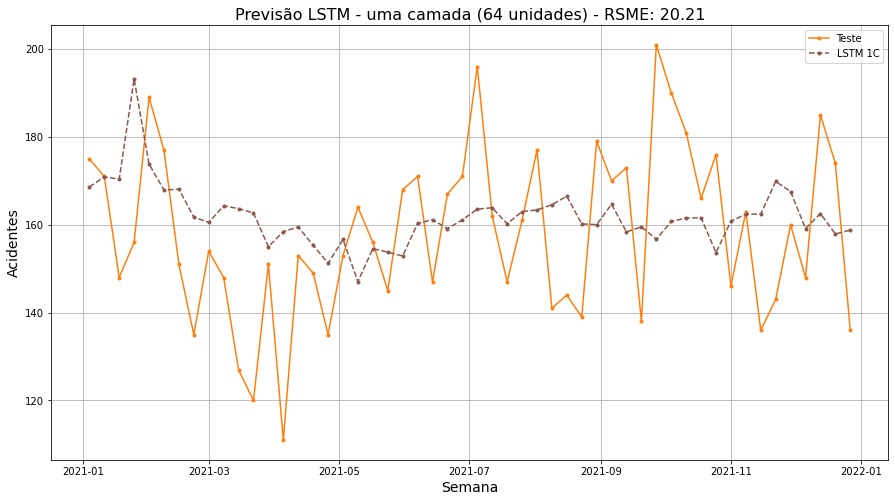

In [34]:
plt.figure(figsize=(15,8))
plt.plot(df_test['ds'], df_test['y'], ls = '-', marker='.', color = 'tab:orange', label = 'Teste')
plt.plot(df_test['ds'], test_predictions_LSTM_umacamada, ls = '--', marker='.', color = 'tab:brown', label = 'LSTM 1C')

plt.title('Previsão LSTM - uma camada (64 unidades) - RSME: %.2f' % RSME_LSTM1C, fontsize=16)
plt.ylabel('Acidentes', fontsize=14)
plt.xlabel('Semana', fontsize=14)

plt.grid()
plt.legend()

plt.savefig("imagesTCC/previsao_lstm1c.pdf", bbox_inches='tight')
plt.show()

## LSTM (duas camadas)

### Normalização e Manipulação

In [35]:
vmax = df_train.y.max()
vmin = df_train.y.min()

df_norm = df.copy()
df_norm['y'] = (df_norm['y'] - vmin)/(vmax - vmin)

series1 = df_norm.y.values[:-horizon]
series2 = df_norm.y.values[horizon:]

# define generator
n_input = 4
generator = TimeseriesGenerator(series1, series2, length=n_input, batch_size=1)

# print each sample
df_norm_x = []
df_norm_y = []
for i in range(len(generator)):
    x, y = generator[i]
    df_norm_x.append(np.transpose(x))
    df_norm_y.append(y)
    #print('%s => %s' % (x, y))

df_norm_x = np.array(df_norm_x)    
df_norm_y = np.array(df_norm_y)

### Definição do Modelo de Rede Neural

In [36]:
batch_size = 1

seed(1)
set_seed(1)

modelLSTM = keras.models.Sequential()
modelLSTM.add(keras.layers.InputLayer((None, 1)))
modelLSTM.add(keras.layers.LSTM(32, return_sequences=True, activation='relu'))
modelLSTM.add(keras.layers.LSTM(32, activation='relu'))
modelLSTM.add(keras.layers.Dropout(0.2))
modelLSTM.add(keras.layers.Dense(1, activation='relu'))
modelLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 32)          4352      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [37]:
# testar mais épocas
epochs = 200

# compilacao e treinamento
modelLSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

### Previsão Walk-Forward LSTM (Apenas na entrada)

In [38]:
test_predictions_LSTM_norm = []
i = 0

train_loop_x = df_norm_x[:-(len_test+horizon-i)]
train_loop_y = df_norm_y[:-(len_test+horizon-i)]

histLSTM = modelLSTM.fit(train_loop_x, train_loop_y,  
                  batch_size=batch_size, epochs=epochs,
                  shuffle=False, verbose=0)

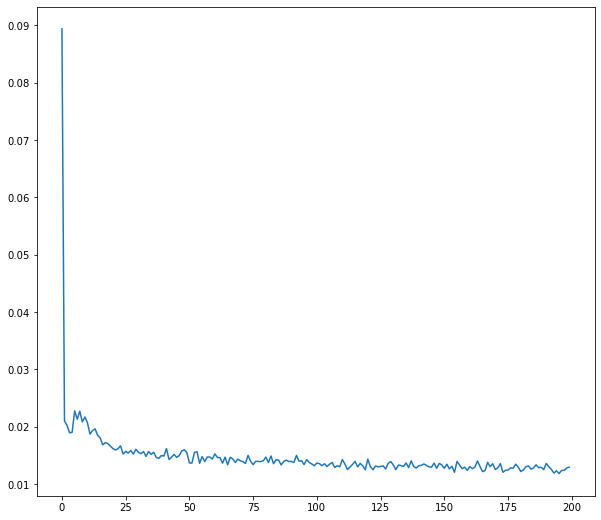

In [39]:
plt.plot(histLSTM.history['loss'])

In [40]:
for i in np.arange(52):    
    train_loop_x = df_norm_x[:-(len_test+horizon-i)]
    train_loop_y = df_norm_y[:-(len_test+horizon-i)]

    test_loop_x = df_norm_x[[-(len_test-i)]]
    
    # realiza predicoes com os dados de treinamento e teste
    forecast = modelLSTM.predict(test_loop_x)
    forecast = np.reshape(forecast, (-1, 1))
    
    test_predictions_LSTM_norm.append(forecast[0][0])
    
test_predictions_LSTM_norm = np.array(test_predictions_LSTM_norm)
test_predictions_LSTM_duascamadas = (test_predictions_LSTM_norm*(vmax - vmin) + vmin)

In [41]:
RSME_LSTM2C = np.sqrt(mean_squared_error(test_true_values, test_predictions_LSTM_duascamadas))
print("LSTM (duas camadas): %.5f" % RSME_LSTM2C)

LSTM (duas camadas): 19.91374


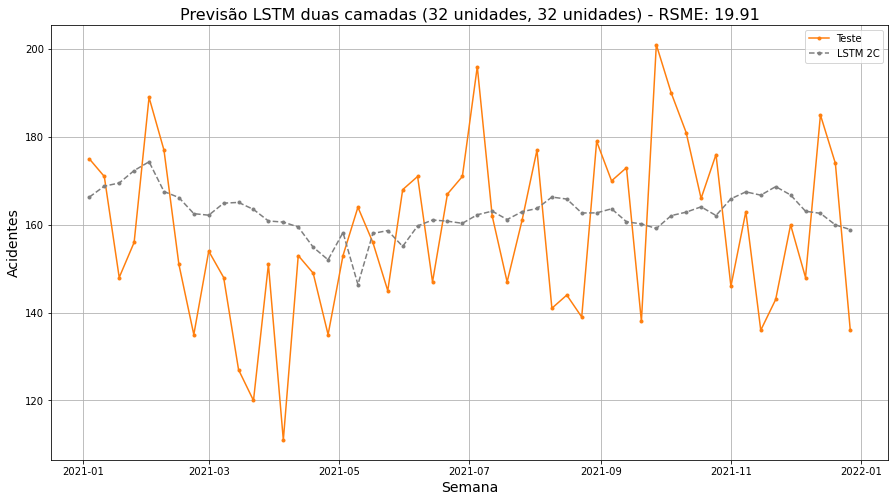

In [42]:
plt.figure(figsize=(15,8))
plt.plot(df_test['ds'], df_test['y'], ls = '-', marker='.', color = 'tab:orange', label = 'Teste')
plt.plot(df_test['ds'], test_predictions_LSTM_duascamadas, ls = '--', marker='.', color = 'tab:grey', label = 'LSTM 2C')

plt.title('Previsão LSTM duas camadas (32 unidades, 32 unidades) - RSME: %.2f' % RSME_LSTM2C, fontsize=16)
plt.ylabel('Acidentes', fontsize=14)
plt.xlabel('Semana', fontsize=14)

plt.grid()
plt.legend()

plt.savefig("imagesTCC/previsao_lstm2c.pdf", bbox_inches='tight')
plt.show()

## Comparação entre os modelos

In [43]:
print("ARIMA: %.5f" % np.sqrt(mean_squared_error(test_true_values, test_predictions_ARIMA)))
print("SARIMA: %.5f" % np.sqrt(mean_squared_error(test_true_values, test_predictions_SARIMA)))
print("PROPHET: %.5f" % np.sqrt(mean_squared_error(test_true_values, test_predictions_PROPHET)))
print("LSTM (uma camada): %.5f" % np.sqrt(mean_squared_error(test_true_values, test_predictions_LSTM_umacamada)))
print("LSTM (duas camadas): %.5f" % np.sqrt(mean_squared_error(test_true_values, test_predictions_LSTM_duascamadas)))

ARIMA: 24.81935
SARIMA: 22.61367
PROPHET: 24.98186
LSTM (uma camada): 20.20785
LSTM (duas camadas): 19.91374


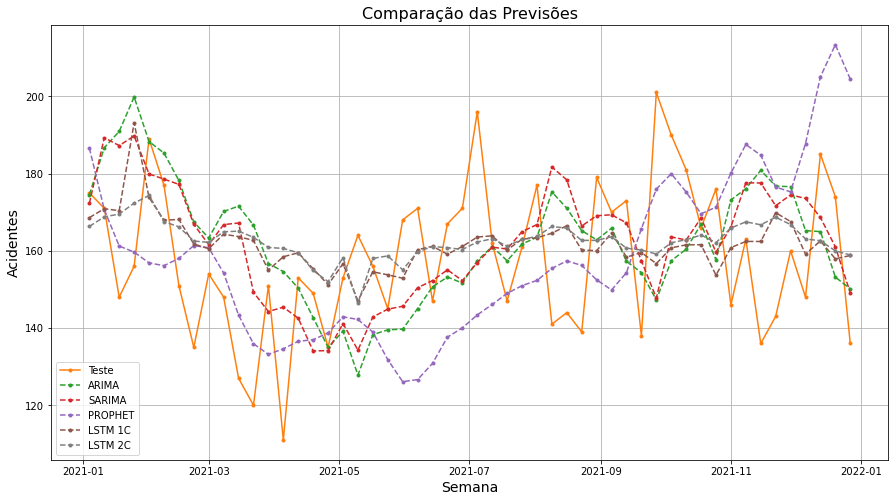

In [44]:
plt.figure(figsize=(15,8))
plt.plot(df_test['ds'], df_test['y'], ls = '-', marker='.', color = 'tab:orange', label = 'Teste')
plt.plot(df_test['ds'], test_predictions_ARIMA, ls = '--', marker='.', color = 'tab:green', label = 'ARIMA')
plt.plot(df_test['ds'], test_predictions_SARIMA, ls = '--', marker='.', color = 'tab:red', label = 'SARIMA')
plt.plot(df_test['ds'], test_predictions_PROPHET, ls = '--', marker='.', color = 'tab:purple', label = 'PROPHET')
plt.plot(df_test['ds'], test_predictions_LSTM_umacamada, ls = '--', marker='.', color = 'tab:brown', label = 'LSTM 1C')
plt.plot(df_test['ds'], test_predictions_LSTM_duascamadas, ls = '--', marker='.', color = 'tab:grey', label = 'LSTM 2C')

plt.title('Comparação das Previsões', fontsize=16)
plt.ylabel('Acidentes', fontsize=14)
plt.xlabel('Semana', fontsize=14)

plt.grid()
plt.legend()

plt.savefig("imagesTCC/comparacao_previsoes.pdf", bbox_inches='tight')
plt.show()